## <h1 align=center><font size = 5>Final Exam - IBM Data Science Capstone - Week 2 Submission
</font></h1>

# Business Problem Introduction

Companies opening up new store fronts, have to deal with a myriad of issues: business licenses, regulatory requirements, sales and business taxes, competitors, and of course the biggest item: location, location, location. Positioning a store front in an advantageous location is one of, if not the, most important, key factor in a business’s ability to survive and thrive. The business problem this analysis attempts to solve, is to assist business owners with finding a set of potential locations to maximize their chances of success in opening a new store front. The specific “client” that this study will address, is a business owner that wants to open a new upscale (Steakhouse) restaurant in the Toronto Canada area.

The overall strategy will be to find the highest revenue generating areas, in combination with the lowest number of potential competitors, within a given area. In addition, the total number of other nearby (non-restaurant) venues will be factored in, which act as additional “magnets” to entice more customers and foot traffic into the area that the business operates in.

Both a text summary of the best potential neighborhoods, as well as a Folium map showing the city of Toronto and the selected potential neighborhoods in graphic form, will be produced by the project.

## Who Would be Interested

The typical client for this kind of service would be any business that wanted to open a new storefront in any of Toronto’s neighborhoods. The customer would be able to get a list of the top 10 neighborhoods that would have the best desired “draw” characteristics, as well as good potential (under-served areas) for the target business. 

While this specific project focuses on selecting restaurant locations, any type of store front business (not just restaurants) could be evaluated, by changing the target venue. 

# Data To Be Used

For this analysis, the following data is needed, in the form of CSV files that will be downloaded and generated as part of the reproducible source input data for this project:
 - Toronto Open Data Portal providing Toronto Neighbor Names and Demographic data for each neightborhood
 - Nominatim network REST API used to retrive geo-coding data (latitude and longitude) for each neighborhood
 - Foursquare Labs network REST API to search and extract Venue information about each neighborhood

# Methodology and Analysis Section

This section includes the data related import and processing modules, including exploratory data analysis based on plots, and processing of data loaded into Python Pandas data frames, to massage and cluster the data being used.

#### First, setup all the python libraries dependencies that we will need.

In [30]:
import numpy as np    # library to handle data in a vectorized manner

import pandas as pd                     # library for data analsysis
pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)

import json                             # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim   # convert an address into latitude and longitude values

import requests                           # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium                             # map rendering library

## !pip install beautifulsoup4
from bs4 import BeautifulSoup             # pull in HTML screen scraper support

import csv                                # CSV processing

from pathlib import Path                  # File exists checking

import time                               # for sleep function

print ('python Libraries have been imported.')

python Libraries have been imported.


<a id='item1'></a>

## Download and Explore Datasets

## Load Neighborhoods and associated Real Estate Prices data

In order to segement the neighborhoods and explore them, create a dataset that contains all the Toronto neighborhoods and their associated districts, based upon XLS/CSV data downloaded from the Toronto Data portal.

In [31]:
# Retrieved CSV list of neighborhoods and associated housing data from Toronto's "Wellbeing Toronto - Housing"
# webpage, from their Open Data Portal at URL:
#  https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#0ee5007f-7c8b-5107-7fa8-24de3ae06f22
# Their XLSX data was downloaded and converted to CSV format in local directory
# Read in that CSV
 
# convert the Toronto neighborhoods CSV file into a pandas dataframe, then print the first few entries

df_toronto_base_raw = pd.read_csv ('Toronto_WB-Housing.csv')

print ('Toronto Neighbourhods and Housing CSV dataset loaded!')
print ('Raw Toronto Neighbourhoods shape is: ', df_toronto_base_raw.shape)

df_toronto_base_raw.head (10)


Toronto Neighbourhods and Housing CSV dataset loaded!
Raw Toronto Neighbourhoods shape is:  (140, 12)


,Neighbourhood,Neighbourhood Id,Home Prices,Mid-Century Highrise Households,Mid-Century Highrise Population,Percent Mid-Century Highrise Households,Percent Mid-Century Highrise Population,Rent Bank Applicants,Social Housing Turnover,Social Housing Units,Social Housing Waiting List,Unnamed: 11
0,West Humber-Clairville,1,317508,690,1810,6.8,5.3,38,0.312500,952,557,NaN
1,Mount Olive-Silverstone-Jamestown,2,251119,4110,13395,42.9,40.9,41,7.000000,1146,1049,NaN
2,Thistletown-Beaumond Heights,3,414216,430,1260,13.4,12.4,7,1.333333,447,270,NaN
3,Rexdale-Kipling,4,392271,600,1050,15.2,10.0,19,4.200000,432,186,NaN
4,Elms-Old Rexdale,5,233832,870,2305,27.3,24.1,14,1.000000,463,239,NaN
5,Kingsview Village-The Westway,6,292861,4465,12445,58.2,57.3,55,9.500000,367,663,NaN
6,Willowridge-Martingrove-Richview,7,511637,2890,7090,35.5,33.2,24,2.000000,561,316,NaN
7,Humber Heights-Westmount,8,491396,1370,2860,35.0,27.0,3,1.812500,669,155,NaN
8,Edenbridge-Humber Valley,9,873268,1550,3630,25.7,24.3,10,0.000000,0,139,NaN
9,Princess-Rosethorn,10,971668,410,1180,11.0,10.5,4,0.000000,0,41,NaN


## Data Wrangling/Cleaning

This section cleans up the data we received, dropping any NaN housing data, removing any duplicates,
and dropping any un-needed columns.

In [32]:
# drop any neighbourhoods that lack housing price data  (should not be any, but just to be sure)
df_toronto_base_raw.dropna (subset=['Home Prices'], inplace=True)

# drop any duplicates  (should not be any, but just to be sure)
df_toronto_base_raw.drop_duplicates (subset=None, keep='first', inplace=True)

# drop unneeded columns (aka grab just the columns we really need)
df_toronto = df_toronto_base_raw[['Neighbourhood','Home Prices']]

# clean things up by sorting into alpha order, then reset Pandas index to renumber them
df_toronto.sort_values (by=['Neighbourhood'],ascending=True,inplace=True)  # sort into order and reset index to 0,1,2, ...
df_toronto = df_toronto.reset_index (drop=True)

print ('Cleaned Toronto Neighbourhoods shape is: ', df_toronto.shape)

df_toronto.head (10)

Cleaned Toronto Neighbourhoods shape is:  (140, 2)


E:\K\Anaconda_v3.6\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Neighbourhood,Home Prices
0,Agincourt North,375307
1,Agincourt South-Malvern West,332710
2,Alderwood,504233
3,Annex,993491
4,Banbury-Don Mills,613647
5,Bathurst Manor,568877
6,Bay Street Corridor,457787
7,Bayview Village,533089
8,Bayview Woods-Steeles,784397
9,Bedford Park-Nortown,1191040


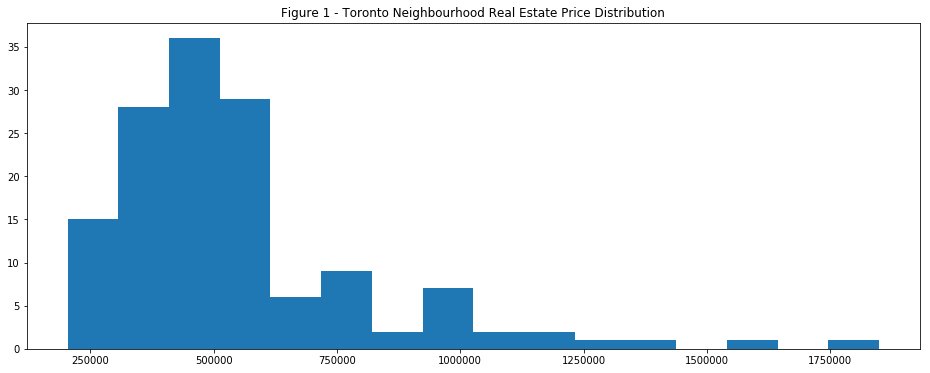

In [33]:
# show a histogram of Real Estate (Home) price disribution

plt.figure(figsize=(16,6))
plt.hist (df_toronto['Home Prices'],16)
plt.title('Figure 1 - Toronto Neighbourhood Real Estate Price Distribution')
plt.show()

In [34]:
# and also get basic stats on the Home Prices data
# Bottom line is we want to target neighbourhoods with Home Prices of 548K and higher as being upscale

df_toronto.describe()

,Home Prices
count,1.400000e+02
mean,5.481934e+05
std,2.676674e+05
min,2.041040e+05
25%,3.749645e+05
50%,4.912100e+05
75%,5.902160e+05
max,1.849084e+06


In [35]:
# Check if the Toronto Neighbourhood geo dataset has been created. If not, create it now.
# Skip re-building the file, if the CSV dataset already exists. Are approx 140 entries.

my_file = Path ("Toronto_Geospatial_Coordinates.csv")
if (my_file.is_file() == False):
    # file does NOT exist. Must create it
    geolocator = Nominatim()     # instantiate the lookup object
    Nominatim (user_agent="my-application")   # set specific application name to avoid default user agent complaint


    csv_geo_file = open ('Toronto_Geospatial_Coordinates.csv', 'w')
    csv_writer   = csv.writer (csv_geo_file)
    csv_writer.writerow (['Neighbourhood', 'Home Prices', 'Latitude', 'Longitude'])   # write out header line

    # NOTE: Nominatim limits stuff to maximum of 1 request per second !!!  (we need to process 127 hoods)
    # loop thru the above pandas dataset and append the Neighbourhood name to Seattle
    # and then do a lookup on that, and save it into a csv file by neighbourhood name
    for i in range(0, len(df_toronto)):
        Neighbourhood  = df_toronto.iloc[i]['Neighbourhood']
        Housing_Price = df_toronto.iloc[i]['Home Prices']
        # a bit brute force, but we only have to do it once (for 127 u)
        address    = Neighbourhood + ', Toronto, Canada'
        location   = geolocator.geocode (address)
        if (location != None):
           Latitude   = location.latitude
           Longitude  = location.longitude
        # if null, will just use the previous Lat/Long as default
        csv_writer.writerow ([Neighbourhood, Housing_Price, Latitude, Longitude])
        print ('Address coords to {} are {}, {}.'.format(address, Latitude, Longitude))
        #
        time.sleep (2)   # Delays for 2 seconds to make Novatim happy. Can also use a float value.
    
    csv_geo_file.close()
    print ('Toronto Geo Coordinates file write complete')


In [36]:
# import the CSV file Toronto_Geospatial_Coordinates.csv that we created earlier, and load into a DataFrame

df_toronto_neighborhood_geo = pd.read_csv ('Toronto_Geospatial_Coordinates.csv')

print ("Total Neighbourhoods: " + str(df_toronto_neighborhood_geo ['Neighbourhood'].nunique()))
print ('Shape of Toronto Neighborhood Geo coordinate shape is ', df_toronto_neighborhood_geo .shape)

df_toronto_neighborhood_geo .head (10)

Total Neighbourhoods: 140
Shape of Toronto Neighborhood Geo coordinate shape is  (140, 4)


,Neighbourhood,Home Prices,Latitude,Longitude
0,Agincourt North,375307,43.808038,-79.266439
1,Agincourt South-Malvern West,332710,43.808038,-79.266439
2,Alderwood,504233,43.601717,-79.545232
3,Annex,993491,43.670338,-79.407117
4,Banbury-Don Mills,613647,43.734804,-79.357243
5,Bathurst Manor,568877,43.763893,-79.456367
6,Bay Street Corridor,457787,43.665275,-79.387528
7,Bayview Village,533089,43.769197,-79.376662
8,Bayview Woods-Steeles,784397,43.798127,-79.382973
9,Bedford Park-Nortown,1191040,43.798127,-79.382973


================================================================
## Setup Four Square credentials
================================================================

In [37]:
# use the 4-Square segmenting/clustering thing
CLIENT_ID = '50BIQWK4SFVUM420YXDPJCP2BGLEJORINZQAZF0SHQEREVIX' # my Foursquare ID
CLIENT_SECRET = '4OF5PFQ0PF4JX5RVA3FF52TNZMBU2JZRIQ00JCH1UDOHHKCW' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version or '20180604'
# CAUTION LIMIT must be same as shape (103). If set to 100 (default) later
# processing dies because the frame shapes don't match (103 vs 100)
LIMIT = 100
print ('Your credentials:')
print ('CLIENT_ID: ' + CLIENT_ID)
print ('CLIENT_SECRET: ' + CLIENT_SECRET)
print ('VERSION: ' + VERSION)
#print ('LIMIT: ' + LIMIT)

Your credentials:
CLIENT_ID: 50BIQWK4SFVUM420YXDPJCP2BGLEJORINZQAZF0SHQEREVIX
CLIENT_SECRET: 4OF5PFQ0PF4JX5RVA3FF52TNZMBU2JZRIQ00JCH1UDOHHKCW
VERSION: 20180605


## Set up Python Functions Needed for processing Four-Square Results


In [9]:
# function to extract basic category for restaraunts and other things
# Venue Cataegory often has two part names, e.g. Restaraunt will have Venues of 'Indian Restaraunt', 'Italian Restaraunt'
# This logic extracts the basic category, e.g. just 'Restaraunt'

def gen_basic_category (category_name):
    name_elements = category_name.split()
    if (len(name_elements) > 1):
        # split returned a tuple with multiple elements. for restaurant, skip the first term, All others strip 2nd term
        if (name_elements[1] == 'Restaurant'):
           return (name_elements[1])
    return (name_elements[0])

In [10]:
# returns indication if the category is a restaurant or not. 1 = yes, 0 = no
# This logic extracts the basic category, e.g. just 'Restaurant'

def is_restaurant (category_name, cumul_count_str):
    cumul_count = int(cumul_count_str)
    name_elements = category_name.split()
    if (len(name_elements) > 1):
        # split returned a tuple with multiple elements. for restaurant, skip the first term, All others strip 2nd term
        if (name_elements[1] == 'Restaurant'):
           cumul_count = cumul_count + 1
    return str(cumul_count)

In [11]:
# returns indication if the category is a steakhouse or not. 1 = yes, 0 = no
# This logic extracts the basic category, e.g. just 'Restaurant' or 'Steakhouse'

def is_steakhouse (category_name, cumul_count_str):
    cumul_count = int(cumul_count_str)
    name_elements = category_name.split()
    if (category_name == 'Steakhouse'):
       cumul_count = cumul_count + 1
    if (category_name == 'SteakHouse'):
       cumul_count = cumul_count + 1
    return str(cumul_count)

### Function to Search for All Venues in an Area (neighborhood)

In [16]:
# generic search for all venues in an area
#def  getNearbyVenues (name, lat, lng, radius=1000):
def  getNearbyVenues (names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print (name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue. only allows STRING fields for each column
        rest_count  = str(0)
        steak_count = str(0)
        venues_list.append ([(
                name, 
                ven['venue']['name'], 
                ven['venue']['categories'][0]['name'],
                gen_basic_category (ven['venue']['categories'][0]['name']),
                ven['venue']['location']['lat'], 
                ven['venue']['location']['lng'],
                lat, 
                lng)   for ven in results])
        # end for

    nearby_venues = pd.DataFrame ([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['Neighbourhood', 
                  'Venue', 
                  'Venue_Category',
                  'Venue_Basic_Category',
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude']
    
    return (nearby_venues)

### Function to Search for a Specific Venue in an Area

In [12]:
# search for a specific type of Venue (food store, electronics store, restaraunt, ...) in an area

def  searchNearbyVenues (names, latitudes, longitudes, search_arg, radius=1000):
    
    venues_list=[]
    #
    for name, lat, lng in zip(names, latitudes, longitudes):
        print (name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            search_arg,
            radius, 
            LIMIT)
            
        # make the GET request, and get returned JSON result
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # extract and return only relevant information for each nearby venue from the JSON reply
        venues_list.append ([(
                name, 
                ven['venue']['name'], 
                ven['venue']['categories'][0]['name'],
                gen_basic_category (ven['venue']['categories'][0]['name']),
                ven['venue']['location']['lat'], 
                ven['venue']['location']['lng'],
                lat, 
                lng)   for ven in results])
        # end for
    
    # convert the collected list of JSON-based venue entries into a Pandas Dataframe
    nearby_venues = pd.DataFrame ([item for venue_list in venues_list for item in venue_list])
    #
    # set the names of the columns to use in the new DataFrame
    nearby_venues.columns = ['Neighbourhood', 
                  'Venue', 
                  'Venue_Category',
                  'Venue_Basic_Category',
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude']
    
    return (nearby_venues)

### Function to Extract type of Venue (Category) from the returned Four-Square data

All the returned information is in the *items* key. This extracts the Category type

In [13]:
# function that extracts the category of the venue

def get_category_type (row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<a id='item2'></a>

## Explore the set of Venues in each of the Neighborhoods

### Run Query for all the venues in a set of neighborhoods, and create a new dataframe called *toronto_venues*.

In [263]:
# invoke the 4-Square functions for each of the 140 neighbourhoods,
# and save the results in a data frame

toronto_venues = getNearbyVenues (names      = df_toronto_neighborhood_geo ['Neighbourhood'],
                                  latitudes  = df_toronto_neighborhood_geo l['Latitude'],
                                  longitudes = df_toronto_neighborhood_geo ['Longitude']
                                 )

Agincourt North
Agincourt South-Malvern West
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bedford Park-Nortown
Beechborough-Greenbrook
Bendale
Birchcliffe-Cliffside
Black Creek
Blake-Jones
Briar Hill-Belgravia
Bridle Path-Sunnybrook-York Mills
Broadview North
Brookhaven-Amesbury
Cabbagetown-South St.James Town
Caledonia-Fairbank
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth-East York
Don Valley Village
Dorset Park
Dovercourt-Wallace Emerson-Juncti
Downsview-Roding-CFB
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Eringate-Centennial-West Deane
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Humbe

#### Check the size and shape of the resulting dataframe

In [264]:
print ("Total Unique Neighbourhoods returned with Venues: " + str(toronto_venues['Neighbourhood'].nunique()))
print ('Total number and shape of venues results returned=', toronto_venues.shape)
toronto_venues.head (10)

Total Unique Neighbourhoods returned with Venues: 140
Total number and shape of venues results returned= (5863, 10)


,Neighbourhood,Venue,Venue_Category,Venue_Basic_Category,Venue_Restaurant_Count,Venue_Steakhouse_Count,Venue Latitude,Venue Longitude,Neighborhood Latitude,Neighborhood Longitude
0,Agincourt North,Saravanaa Bhavan South Indian Restaurant,Indian Restaurant,Restaurant,1,0,43.810117,-79.269275,43.808038,-79.266439
1,Agincourt North,Samosa King - Embassy Restaurant,Indian Restaurant,Restaurant,1,0,43.810152,-79.257316,43.808038,-79.266439
2,Agincourt North,Booster Juice,Juice Bar,Juice,0,0,43.809915,-79.269382,43.808038,-79.266439
3,Agincourt North,Shoppers Drug Mart,Pharmacy,Pharmacy,0,0,43.808119,-79.269744,43.808038,-79.266439
4,Agincourt North,Dollarama,Discount Store,Discount,0,0,43.808889,-79.268889,43.808038,-79.266439
5,Agincourt North,The Beer Store,Beer Store,Beer,0,0,43.809286,-79.263676,43.808038,-79.266439
6,Agincourt North,Subway,Sandwich Place,Sandwich,0,0,43.809007,-79.267627,43.808038,-79.266439
7,Agincourt North,TD Canada Trust,Bank,Bank,0,0,43.809989,-79.268878,43.808038,-79.266439
8,Agincourt North,Congee Town 太皇名粥,Chinese Restaurant,Restaurant,1,0,43.809035,-79.267634,43.808038,-79.266439
9,Agincourt North,Tim Hortons,Coffee Shop,Coffee,0,0,43.809721,-79.269565,43.808038,-79.266439


In [265]:
# For debugging, save a copy of the returned toronto_venues dataframe
debug_flag1 = True
if (debug_flag1 == True):
    toronto_venues.to_csv ('toronto_all_venues.csv')
#   df.to_csv('results.csv', index=False, header=True)   # strips off Index column at front

In [38]:
# For debugging, restore the copy of the returned toronto_venues dataframe (restart sequence from here rather than re-run query)
debug_flag2 = True
if (debug_flag2 == True):
    toronto_venues = []
    toronto_venues = pd.read_csv ('toronto_all_venues.csv')
    toronto_venues.head (5)

### Get how many Total venues were returned by Four-Square (all neighborhoods)

In [39]:
print ('{} total venues were returned by Foursquare.'.format(toronto_venues.shape[0]))

5863 total venues were returned by Foursquare.


### Get how many unique categories can be curated from all the returned venues

In [40]:
print ('There are {} unique categories.'.format(len(toronto_venues['Venue_Category'].unique())))

There are 310 unique categories.


### Aggregate How many venues were returned for each neighborhood

In [41]:
toronto_venues.groupby ('Neighbourhood').count()

,Unnamed: 0,Venue,Venue_Category,Venue_Basic_Category,Venue_Restaurant_Count,Venue_Steakhouse_Count,Venue Latitude,Venue Longitude,Neighborhood Latitude,Neighborhood Longitude
Neighbourhood,,,,,,,,,,
Agincourt North,31,31,31,31,31,31,31,31,31,31
Agincourt South-Malvern West,31,31,31,31,31,31,31,31,31,31
Alderwood,22,22,22,22,22,22,22,22,22,22
Annex,100,100,100,100,100,100,100,100,100,100
Banbury-Don Mills,27,27,27,27,27,27,27,27,27,27
Bathurst Manor,16,16,16,16,16,16,16,16,16,16
Bay Street Corridor,100,100,100,100,100,100,100,100,100,100
Bayview Village,54,54,54,54,54,54,54,54,54,54
Bayview Woods-Steeles,8,8,8,8,8,8,8,8,8,8


### Generate a column containing the Total Number of Venues in each neighborhood

In [42]:
# get a dataframe with the results of the groupby Neighborhood
toronto_venues_grouped = toronto_venues.groupby(['Neighbourhood']).size().reset_index(name='Venues_Count')
#toronto_venues_grouped.head(15)

# now merge the venue counts into the main Neighborhoods DataFrame
toronto_data_vm = pd.merge (df_toronto_neighborhood_geo, toronto_venues_grouped, how='inner', on='Neighbourhood')
toronto_data_vm.head (15)

,Neighbourhood,Home Prices,Latitude,Longitude,Venues_Count
0,Agincourt North,375307,43.808038,-79.266439,31
1,Agincourt South-Malvern West,332710,43.808038,-79.266439,31
2,Alderwood,504233,43.601717,-79.545232,22
3,Annex,993491,43.670338,-79.407117,100
4,Banbury-Don Mills,613647,43.734804,-79.357243,27
5,Bathurst Manor,568877,43.763893,-79.456367,16
6,Bay Street Corridor,457787,43.665275,-79.387528,100
7,Bayview Village,533089,43.769197,-79.376662,54
8,Bayview Woods-Steeles,784397,43.798127,-79.382973,8
9,Bedford Park-Nortown,1191040,43.798127,-79.382973,8


### Generate aggregate counts of total Restaraunts and (competitive) Steak Houses for each neighborhood

In [43]:
# make the Neighbourhood column as the index, instead of numeric 0-n
# This makes it easy to do row-based .iloc lookups
toronto_data_vm.set_index ('Neighbourhood', inplace=True)

# groupby doesn't give us the counts we want, so we have to do it the old fashioned way
# and loop through each venue's row, lookup its neighborhood, and add to the neighborheood's
# count if there is a Steak House or Restaraunt venue in that neighborhood.

toronto_data_vm ['Venue_Num_Steakhouses'] = 0    # create new columns and clear initial counts
toronto_data_vm ['Venue_Num_Restaraunts'] = 0

for i in range(len(toronto_venues)):                          # walk thru Venue DataFrame, row by row
    nhood    = toronto_venues.iloc[i]['Neighbourhood']        # get neighborhood name for this row
    ven_type = toronto_venues.iloc[i]['Venue_Basic_Category']
    if (ven_type == 'Steakhouse' or ven_type == 'SteakHouse'):
        val = toronto_data_vm.get_value (nhood, 'Venue_Num_Steakhouses')  # Brute force, but it WORKS
        val += 1
        toronto_data_vm.set_value (nhood, 'Venue_Num_Steakhouses', val)   # works because Index = Neighbourhood
    if (ven_type == 'Restaurant'):
        val = toronto_data_vm.get_value (nhood, 'Venue_Num_Restaraunts')
        val += 1
        toronto_data_vm.set_value (nhood, 'Venue_Num_Restaraunts', val)
    #print (str(i) + '  ' + nhood + '  ' + ven_type)

toronto_data_vm.head(10)

E:\K\Anaconda_v3.6\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
E:\K\Anaconda_v3.6\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
E:\K\Anaconda_v3.6\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
E:\K\Anaconda_v3.6\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,Home Prices,Latitude,Longitude,Venues_Count,Venue_Num_Steakhouses,Venue_Num_Restaraunts
Neighbourhood,,,,,,
Agincourt North,375307,43.808038,-79.266439,31,0,5
Agincourt South-Malvern West,332710,43.808038,-79.266439,31,0,5
Alderwood,504233,43.601717,-79.545232,22,0,1
Annex,993491,43.670338,-79.407117,100,0,34
Banbury-Don Mills,613647,43.734804,-79.357243,27,0,3
Bathurst Manor,568877,43.763893,-79.456367,16,0,0
Bay Street Corridor,457787,43.665275,-79.387528,100,1,22
Bayview Village,533089,43.769197,-79.376662,54,0,8
Bayview Woods-Steeles,784397,43.798127,-79.382973,8,0,0


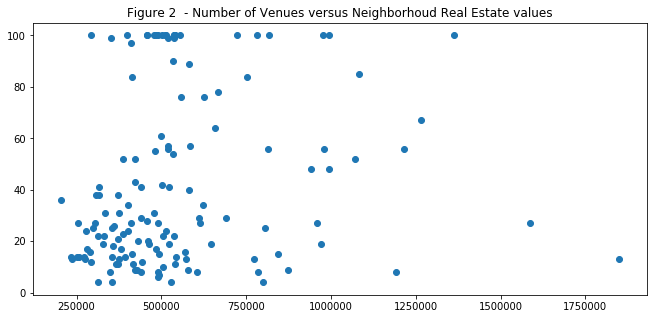

In [74]:
# do a X,Y scatter plot comparing # venues to Real Estate prices for each of the neighborhoods
# to see if there is any correlation
x = toronto_data_vm ['Home Prices']
y = toronto_data_vm ['Venues_Count']
plt.figure(figsize= (11,5))
plt.scatter (x,y)
plt.title ('Figure 2  - Number of Venues versus Neighborhoud Real Estate values')
plt.show()

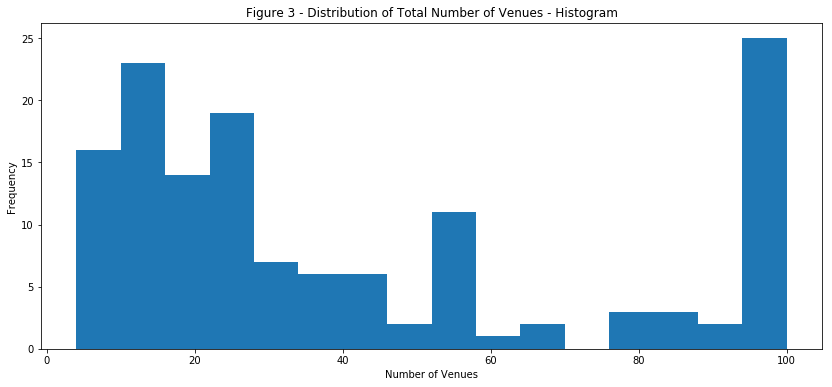

In [54]:
plt.figure(figsize=(14,6))
plt.hist (toronto_data_vm ['Venues_Count'],16)
plt.xlabel('Number of Venues')
plt.ylabel('Frequency')
plt.title('Figure 3 - Distribution of Total Number of Venues - Histogram')
plt.show()

<a id='item3'></a>

## Analyze the Venues in Each Neighborhood

Use "one hot encoding" to create a numerical matrix of each type of venue in each neighborhood.

In [55]:
#######################
#  one hot encoding
#######################
toronto_onehot = pd.get_dummies (toronto_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighbourhood column back into dataframe (gets appended to tail)
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 
# then move that neighbourhood column to the first column
fixed_columns  = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head(35)

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Street Art,Strip Club,Supermark

Get the new dataframe size.

In [56]:
toronto_onehot.shape

(5863, 311)

#### Define Python Function to put Venues data into a *pandas* dataframe and sorting them in descending order

In [61]:
def return_most_common_venues (row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [75]:
x = toronto_data_vm.iloc[0:10, 0]       # verify the first 10 rows, and column 1 = 'Home Prices'
print (x)

Neighbourhood
Agincourt North                  375307
Agincourt South-Malvern West     332710
Alderwood                        504233
Annex                            993491
Banbury-Don Mills                613647
Bathurst Manor                   568877
Bay Street Corridor              457787
Bayview Village                  533089
Bayview Woods-Steeles            784397
Bedford Park-Nortown            1191040
Name: Home Prices, dtype: int64


In [76]:
toronto_data_vm.head(10)

,Home Prices,Latitude,Longitude,Venues_Count,Venue_Num_Steakhouses,Venue_Num_Restaraunts,Cluster Labels
Neighbourhood,,,,,,,
Agincourt North,375307,43.808038,-79.266439,31,0,5,0
Agincourt South-Malvern West,332710,43.808038,-79.266439,31,0,5,0
Alderwood,504233,43.601717,-79.545232,22,0,1,0
Annex,993491,43.670338,-79.407117,100,0,34,2
Banbury-Don Mills,613647,43.734804,-79.357243,27,0,3,0
Bathurst Manor,568877,43.763893,-79.456367,16,0,0,0
Bay Street Corridor,457787,43.665275,-79.387528,100,1,22,0
Bayview Village,533089,43.769197,-79.376662,54,0,8,0
Bayview Woods-Steeles,784397,43.798127,-79.382973,8,0,0,2


# Cluster the Neighborhoods


Run *k*-means to cluster the neighborhoods into several clusters.

Did previous runs using cluster sizes of 3,4,5,6.  Using 3 seems to give the best results.

In [77]:
# set number of clusters:   3 yields 24 candidates and is well separated, 4 is mediocre,  5 is Ok
kclusters = 3

# No need to drop 'Neighbourhood' column, because we re-assigned it to be the index
toronto_grouped_clustering = toronto_data_vm.drop (['Latitude','Longitude','Venue_Num_Steakhouses','Venue_Num_Restaraunts'], 1)
# print shape of resulting dataframe to be input to Kmeans
print ('Shape of KMeans input dataframe = ', toronto_grouped_clustering.shape)

# run k-means clustering
kmeans = KMeans (n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# based on multiple runs for this Dataset, the Kmeans algorithm assigns the (Y value) lowest
# cluster at 0, and the highest cluster at kclusters-1
# Print out the total number of entries in the highest cluster
number_highend_hoods = np.count_nonzero (kmeans.labels_ == (kclusters-1))
print ('The number of high end Neighborhoods in the top cluster =', number_highend_hoods)

# show the cluster labels generated for each row in the dataframe. The kmeans.labels_ are passed back in an np.ndarray
kmeans.labels_


Shape of KMeans input dataframe =  (140, 3)
The number of high end Neighborhoods in the top cluster = 24


array([0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 0])

Create a new dataframe that includes the cluster number as well as rest of key neighborhood info (Housing Prices, Venue totals).

In [78]:
#################################################################################################################
# Append the Kmeans cluster labels to the summary Neighborhood data (Name, House Prices, Lat, Long, Venue Totals)
#################################################################################################################

toronto_merged = toronto_data_vm

# add clustering labels from above Kmeans clustering
toronto_merged['Cluster Labels'] = kmeans.labels_

toronto_merged.head (10)

,Home Prices,Latitude,Longitude,Venues_Count,Venue_Num_Steakhouses,Venue_Num_Restaraunts,Cluster Labels
Neighbourhood,,,,,,,
Agincourt North,375307,43.808038,-79.266439,31,0,5,0
Agincourt South-Malvern West,332710,43.808038,-79.266439,31,0,5,0
Alderwood,504233,43.601717,-79.545232,22,0,1,0
Annex,993491,43.670338,-79.407117,100,0,34,2
Banbury-Don Mills,613647,43.734804,-79.357243,27,0,3,0
Bathurst Manor,568877,43.763893,-79.456367,16,0,0,0
Bay Street Corridor,457787,43.665275,-79.387528,100,1,22,0
Bayview Village,533089,43.769197,-79.376662,54,0,8,0
Bayview Woods-Steeles,784397,43.798127,-79.382973,8,0,0,2


Figure 4


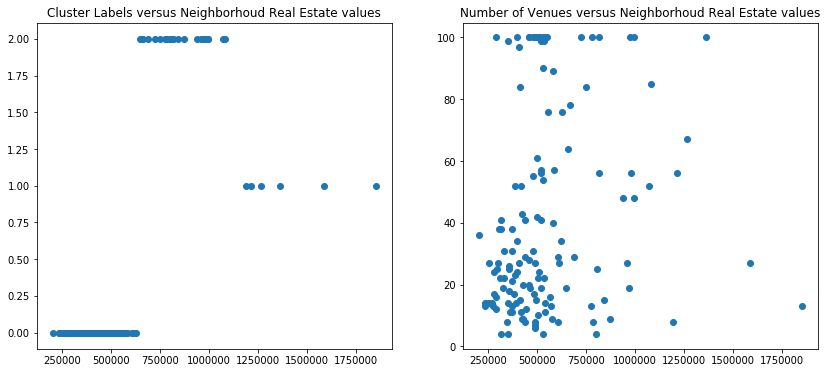

In [79]:
# Show the neighbor cluster numbers and associated Housing Prices on a scatter plot, 
# and compare it side by each to the earlier scatterplot we did showing House Prices and # venues
print ("Figure 4")
fig, axes = plt.subplots (1,2, figsize=(14,6))
x1 = toronto_merged ['Home Prices']
y1 = toronto_merged ['Cluster Labels']
axes[0].set_title ('Cluster Labels versus Neighborhoud Real Estate values')
axes[0].scatter (x1,y1)

x2 = toronto_merged ['Home Prices']
y2 = toronto_merged ['Venues_Count']
axes[1].set_title ('Number of Venues versus Neighborhoud Real Estate values')
axes[1].scatter (x2,y2)

plt.show()

### Create new dataframe and display the top 10 candidate neighborhoods

In [80]:
# extract just the venues matching the top cluster number.  Sort them in descendng (highest first)

toronto_sorted_clusters = toronto_merged.sort_values('Cluster Labels', ascending=False)

# extract those high-end neighborhoods into their own dataframe
toronto_highest_cluster = toronto_sorted_clusters[:number_highend_hoods]

# then res0rt that to get the neighborhoods with the highest number venues, which should yuield the highest foot traffic
toronto_highest_sorted = toronto_highest_cluster.sort_values('Venues_Count', ascending=False)

# extract the top 10 from that list, sorting them to have least # of competitive steakhouses order (under-served area hopefully)
toronto_top_10_candidates = toronto_highest_sorted[:10].sort_values('Venue_Num_Steakhouses', ascending=True)
toronto_top_10_candidates.head(10)

,Home Prices,Latitude,Longitude,Venues_Count,Venue_Num_Steakhouses,Venue_Num_Restaraunts,Cluster Labels
Neighbourhood,,,,,,,
North Riverdale,818592,43.665470,-79.352594,100,0,17,2
Trinity-Bellwoods,723909,43.647627,-79.413879,100,0,24,2
Palmerston-Little Italy,781568,43.655879,-79.410076,100,0,22,2
Annex,993491,43.670338,-79.407117,100,0,34,2
The Beaches,751945,43.671024,-79.296712,84,0,12,2
Runnymede-Bloor West Village,666204,43.651778,-79.475923,78,0,15,2
Wychwood,656868,43.682094,-79.423855,64,0,23,2
Casa Loma,1083381,43.678111,-79.409408,85,1,15,2
Mount Pleasant East,815247,43.708417,-79.390135,56,1,17,2


## Visualize the resulting candidate Neighborhoods in a Folium Map

In [81]:
address = 'Toronto, CANADA'
geolocator = Nominatim()
location = geolocator.geocode (address)
latitude = location.latitude
longitude = location.longitude
#print ('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))#torontodf_seattle_data.shape

E:\K\Anaconda_v3.6\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [82]:
# create a map showing the locations of the recommended "Top 10" neighborhoods

map_clusters = folium.Map (location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange (kclusters)

ys = [i+x+(i*x)**2 for i in range(kclusters)]

# colors = {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};

colors_array = cm.rainbow (np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['g', 'r', 'c', 'm', 'y', 'k', 'w', 'b' ]  # always shows black !

# add markers to the map
markers_colors = []
#for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
# Note that toronto_merged.index = 'Neighbourhood' column
#for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged.index, toronto_merged['Cluster Labels']):
for lat, lon, poi, cluster in zip(toronto_top_10_candidates['Latitude'],toronto_top_10_candidates['Longitude'],
    toronto_top_10_candidates.index, toronto_top_10_candidates['Cluster Labels']):
    label = folium.Popup (str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker (
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0], # color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

# End of Data Analysis

See associated Report for further explanation of the results.